<a href="https://colab.research.google.com/github/FrostyXD18/QCNN/blob/main/new_q_cnn_cataract_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# jr2ngb_cataractdataset_path = kagglehub.dataset_download('jr2ngb/cataractdataset')
# andrewmvd_ocular_disease_recognition_odir5k_path = kagglehub.dataset_download('andrewmvd/ocular-disease-recognition-odir5k')

# print('Data source import complete.')


In [ ]:
# ─── VERY FIRST CELL ───────────────────────────────────────────────────────────
import os
# Ask TF to grow GPU memory as needed (instead of pre-allocating all)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Now import TF
import tensorflow as tf

# Discover GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Found {len(gpus)} GPUs → using MirroredStrategy with {strategy.num_replicas_in_sync} replicas")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found → using default (CPU) strategy")
# ───────────────────────────────────────────────────────────────────────────────


Found 2 GPUs → using MirroredStrategy with 2 replicas


In [ ]:
!pip install efficientnet qiskit
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 68.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 36.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
SEED = 40
EPOCHS = 50
BATCH_SIZE = 50
IMG_HEIGHT = 192
IMG_WIDTH = 256

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

In [ ]:
# cataract dataset
IMG_ROOT = '/kaggle/input/cataractdataset/dataset'
IMG_DIR = [IMG_ROOT+'/1_normal',
           IMG_ROOT+'/2_cataract',
           IMG_ROOT+'/2_glaucoma',
           IMG_ROOT+'/3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx')
# ocu_df

## Process Cataract dataset <a name="process1"> </a>

In [ ]:
# cat_df = pd.DataFrame(0,columns=['paths', 'cataract'],index=range(601))
# filepaths = glob.glob(IMG_ROOT + '*/*/*')
# for i, filepath in enumerate(filepaths):
#     filepath = os.path.split(filepath)
#     cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
# #     print(filepath[0])
#     if filepath[0] == IMG_DIR[0]:    # normal
#         cat_df.iloc[i, 1] = 0
#     elif filepath[0] == IMG_DIR[1]:  # cataract
#         cat_df.iloc[i, 1] = 1
#     elif filepath[0] == IMG_DIR[2]:  # glaucoma
#         cat_df.iloc[i, 1] = 2
#     elif filepath[0] == IMG_DIR[3]:  # retine_disease
#         cat_df.iloc[i, 1] = 3

# # only sample normal and cataract
# cat_df = cat_df.query('0 <= cataract < 2')
# cat_df.head()

In [ ]:
# Initialize the DataFrame with the correct dtype for 'paths'
cat_df = pd.DataFrame(columns=['paths', 'cataract'], index=range(601), dtype=object)

filepaths = glob.glob(IMG_ROOT + '*/*/*')

for i, filepath in enumerate(filepaths):
    # Split the filepath into directory and filename using os.path.split
    directory, filename = os.path.split(filepath)

    # Construct and assign the full file path to the 'paths' column
    full_path = os.path.join(directory, filename)
    cat_df.loc[i, 'paths'] = full_path

    # Assign the cataract label based on directory name
    if directory == IMG_DIR[0]:
        cat_df.loc[i, 'cataract'] = 0
    elif directory == IMG_DIR[1]:
        cat_df.loc[i, 'cataract'] = 1
    elif directory == IMG_DIR[2]:
        cat_df.loc[i, 'cataract'] = 2
    elif directory == IMG_DIR[3]:
        cat_df.loc[i, 'cataract'] = 3

# Filter the DataFrame to include only normal and cataract images
cat_df = cat_df.query('0 <= cataract < 2')
cat_df.head()

,paths,cataract
100,/kaggle/input/cataractdataset/dataset/2_catara...,1
101,/kaggle/input/cataractdataset/dataset/2_catara...,1
102,/kaggle/input/cataractdataset/dataset/2_catara...,1
103,/kaggle/input/cataractdataset/dataset/2_catara...,1
104,/kaggle/input/cataractdataset/dataset/2_catara...,1


Number of normal and cataract images
cataract
0    300
1    100
Name: count, dtype: int64


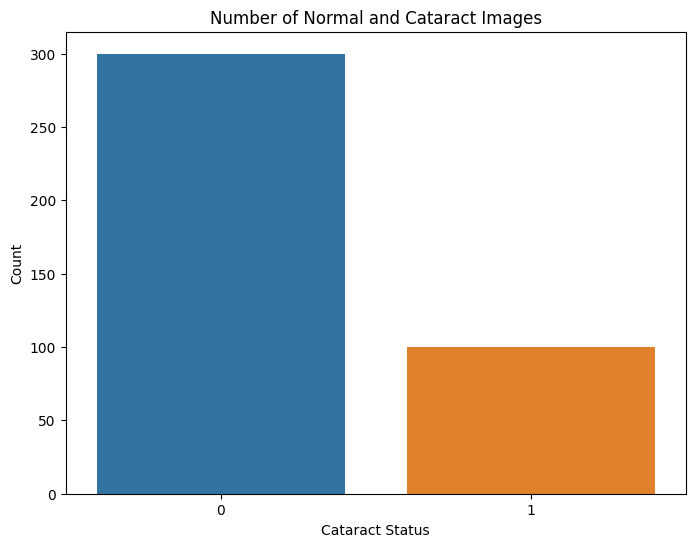

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

# Countplot
plt.figure(figsize=(8, 6))
sns.countplot(x='cataract', data=cat_df)
plt.title('Number of Normal and Cataract Images')
plt.xlabel('Cataract Status')
plt.ylabel('Count')
plt.show()

In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords'].apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords'].apply(lambda x: has_cataract_mentioned(x))

ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,left_eye_cataract,right_eye_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,0,0
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,0,0


In [ ]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']].rename(columns={'left_eye_cataract':'cataract'})

le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)

re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']].rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)


print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
cataract
0    3341
1     159
Name: count, dtype: int64

Number of right eye images
cataract
0    3346
1     154
Name: count, dtype: int64


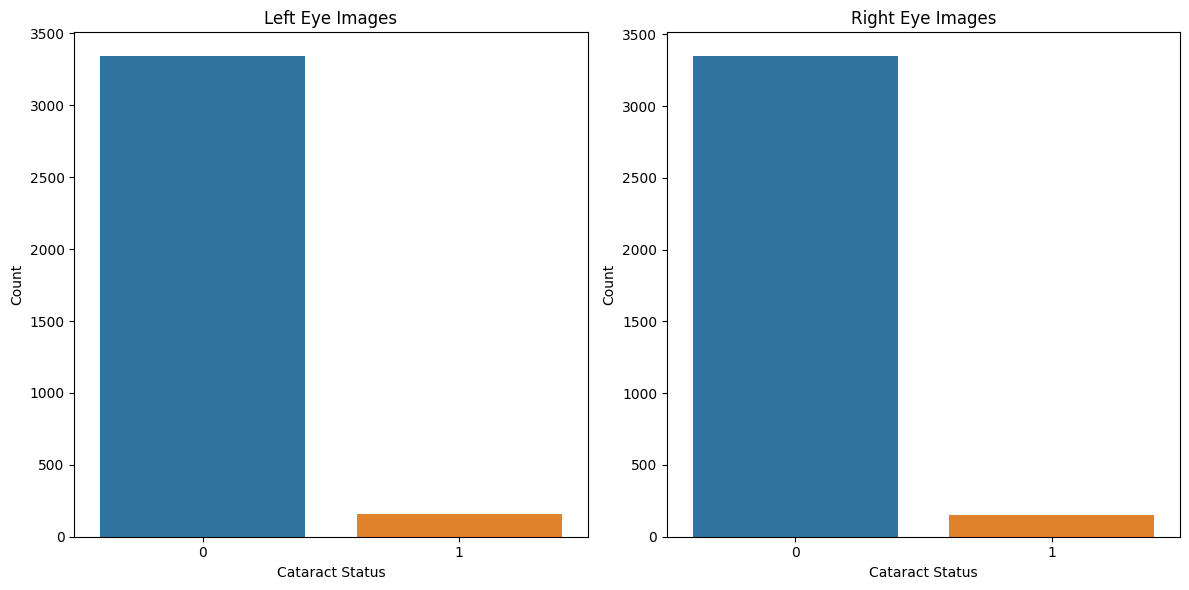

In [ ]:
# Countplot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='cataract', data=le_df, ax=ax[0])
ax[0].set_title('Left Eye Images')
ax[0].set_xlabel('Cataract Status')
ax[0].set_ylabel('Count')

sns.countplot(x='cataract', data=re_df, ax=ax[1])
ax[1].set_title('Right Eye Images')
ax[1].set_xlabel('Cataract Status')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# def downsample(df):
#     df = pd.concat([
#         df.query('cataract==1'),
#         df.query('cataract==0').sample(sum(df['cataract']),random_state=SEED)
#     ])
#     return df


# le_df = downsample(le_df)
# re_df = downsample(re_df)

# print('Number of left eye images')
# print(le_df['cataract'].value_counts())
# print('\nNumber of right eye images')
# print(re_df['cataract'].value_counts())

In [ ]:
ocu_df = pd.concat([le_df, re_df])

df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,/kaggle/input/cataractdataset/dataset/2_catara...,1
1,/kaggle/input/cataractdataset/dataset/2_catara...,1
2,/kaggle/input/cataractdataset/dataset/2_catara...,1
3,/kaggle/input/cataractdataset/dataset/2_catara...,1
4,/kaggle/input/cataractdataset/dataset/2_catara...,1
...,...,...
7395,/kaggle/input/ocular-disease-recognition-odir5...,0
7396,/kaggle/input/ocular-disease-recognition-odir5...,0
7397,/kaggle/input/ocular-disease-recognition-odir5...,0
7398,/kaggle/input/ocular-disease-recognition-odir5...,0


In [ ]:
print(len(df[df['cataract']==1]))
print(len(df[df['cataract']==0]))

413
6987


In [ ]:
!pip install --upgrade qiskit-aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit_aer import AerSimulator  # Import the AerSimulator directly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.3 MB/s eta 0:00:00:00:010:01


# QFT

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image

def quantum_filter_transformation(image_segment):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr, cr)

    # Encoding
    qc.rx(float(np.pi * image_segment[0, 0, 0]), qr[0])
    qc.rx(float(np.pi * image_segment[0, 1, 0]), qr[1])

    # Random quantum circuit
    qc.h(qr)
    qc.cx(qr[0], qr[1])

    # Measurement
    qc.measure(qr, cr)

    # Execute the circuit
    simulator = AerSimulator()
    job = simulator.run(qc, shots=1000)
    result = job.result().get_counts()

    # Decode the result
    expectation_values = [result.get('00', 0), result.get('01', 0), result.get('10', 0), result.get('11', 0)]
    return np.array(expectation_values) / 1000



def apply_qft(image):
    h, w, _ = image.shape
    output = np.zeros((h//2, w//2, 4))
    for i in range(0, h, 2):
        for j in range(0, w, 2):
            segment = image[i:i+2, j:j+2]
            output[i//2, j//2] = quantum_filter_transformation(segment)
    return output

# Main preprocessing pipeline
def preprocess_dataset(df):
    X = []
    y = df['cataract'].values

    for path in tqdm(df['paths'], desc="Preprocessing Images"):
        image = preprocess_image(path)
        if isinstance(image, tf.Tensor):
            image = image.numpy()  # Convert TensorFlow tensor to numpy array
        qft_image = apply_qft(image)
        X.append(qft_image)

    X = np.array(X)
    return X, y

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            # Memory growth must be set before GPUs have been initialized
            pass
    strategy = tf.distribute.MirroredStrategy()
    print(f"Found {len(gpus)} GPUs → using MirroredStrategy with {strategy.num_replicas_in_sync} replicas")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found → using default (CPU) strategy")


Found 2 GPUs → using MirroredStrategy with 2 replicas


In [ ]:
# Separate the two classes
cataract_df = df[df['cataract'] == 1]
non_cataract_df = df[df['cataract'] == 0]

# Count the number of cataract images
num_cataract = len(cataract_df)  # Should be 413

# Calculate the desired total dataset size so that 30% are cataract images
desired_total = int(num_cataract / 0.3)  # Approximately 1377 images
# Calculate the number of non-cataract images needed
desired_non_cataract = desired_total - num_cataract -500 # Approximately 964 images

# Randomly sample the required number of non-cataract images
non_cataract_sample = non_cataract_df.sample(n=desired_non_cataract, random_state=42)

# Combine the cataract images with the sampled non-cataract images
new_df = pd.concat([cataract_df, non_cataract_sample])

# Shuffle the new dataset
new_df = new_df.sample(frac=1).reset_index(drop=True)

# Check the distribution
print(new_df['cataract'].value_counts())

cataract
0    463
1    413
Name: count, dtype: int64


In [ ]:
# X, y = preprocess_dataset(new_df)

In [ ]:
## import kerastuner as kt
from tensorflow import keras
import numpy as np

# 1) Define a HyperModel for your QCNN
class QCNNHyperModel(kt.HyperModel):
    def __init__(self, input_shape, num_classes=2):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        inputs = keras.Input(self.input_shape)

        # Classical conv block
        x = inputs
        for i in range(hp.Int("conv_blocks", 1, 3)):
            filters = hp.Int(f"filters_block{i}", 16, 128, step=16)
            x = keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
            x = keras.layers.MaxPool2D()(x)

        # Flatten before quantum
        x = keras.layers.Flatten()(x)

        # Optional dense before quantum
        x = keras.layers.Dense(hp.Int("dense_pre_qc", 32, 256, step=32),
                               activation="relu")(x)

        # ---- Your quantum feature transform layer ----
        # here we wrap apply_qft as a Lambda so it can be tuned too
        shots = hp.Choice("qft_shots", [100, 500, 1000])
        x = keras.layers.Lambda(lambda img: apply_qft_with_shots(img, shots),
                                name="qft_layer")(x)
        # ----------------------------------------------

        # Classical head
        x = keras.layers.Dense(hp.Int("dense_post_qc", 32, 128, step=32),
                               activation="relu")(x)
        outputs = keras.layers.Dense(self.num_classes, activation="softmax")(x)

        model = keras.Model(inputs, outputs)

        # Compile with tunable learning rate
        lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        model.compile(
            optimizer=keras.optimizers.Adam(lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

# 2) Helper to wrap your existing apply_qft for tuning
def apply_qft_with_shots(flat_inputs, shots):
    # assume flat_inputs is a batch of flattened QFT-ready patches
    # you’d reshape and run your quantum_filter_transformation with `shots`
    # for simplicity here, we just call your existing apply_qft
    # but you’d modify quantum_filter_transformation to accept `shots`
    return apply_qft(flat_inputs)  # placeholder

# 3) Prepare your data
X, y = preprocess_dataset(new_df)    # this runs QFT with your default shot=1000
# If you’re tuning shots, you might want to preprocess at the pixel level,
# then let the Lambda layer run QFT during training.

# 4) Set up and run the tuner
tuner = kt.RandomSearch(
    QCNNHyperModel(input_shape=X.shape[1:], num_classes=2),
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="qcnn_tuning",
    project_name="cataract_qcnn"
)

tuner.search(X, y,
             epochs=20,
             validation_split=0.2,
             batch_size=kt.HyperParameters().Choice("batch_size", [16, 32, 64]))

# 5) Retrieve and build the best model
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best config:")
for key in best_hp.values:
    print(f"  {key}: {best_hp.get(key)}")

best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

# Finally, retrain or evaluate the best_model as you like

In [ ]:
# Save the preprocessed data to a compressed .npz file
np.savez('preprocessed_data.npz', X=X, y=y)

print("Preprocessed data saved to 'preprocessed_data.npz'")

Preprocessed data saved to 'preprocessed_data.npz'


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class QuCNetEnhanced(tf.keras.Model):
    def __init__(self):
        super(QuCNetEnhanced, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D((2, 2))

        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))

        self.conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.5)
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        return self.dense2(x)

model = QuCNetEnhanced()


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                               tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)])

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.4966 - loss: 4.7693 - val_accuracy: 0.5429 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4897 - loss: 0.6932 - val_accuracy: 0.5429 - val_loss: 1.3310 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5506 - loss: 0.6929 - val_accuracy: 0.5429 - val_loss: 1.4829 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5461 - loss: 0.6927 - val_accuracy: 0.5429 - val_loss: 1.3026 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5501 - loss: 0.6925 - val_accuracy: 0.5429 - val_loss: 0.8460 - learning_rate: 5.0000e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5611 - loss: 0.6921 - val_accuracy: 0.4571 - val_loss: 0.7073 - learning_rate: 5.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5440 - loss: 0.6923 - val_

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'history' is the History object returned from model.fit()
# Convert the history.history dict to a pandas DataFrame
history_df = pd.DataFrame(history.history)

# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model.save('Q_CNN_cataract_detection_model.h5')

# Alternatively, you can save just the weights
model.save_weights('Q_CNN_cataract_detection_model_.weights.h5')

print("Model saved successfully.")


NameError: name 'model' is not defined